# Watch self-play

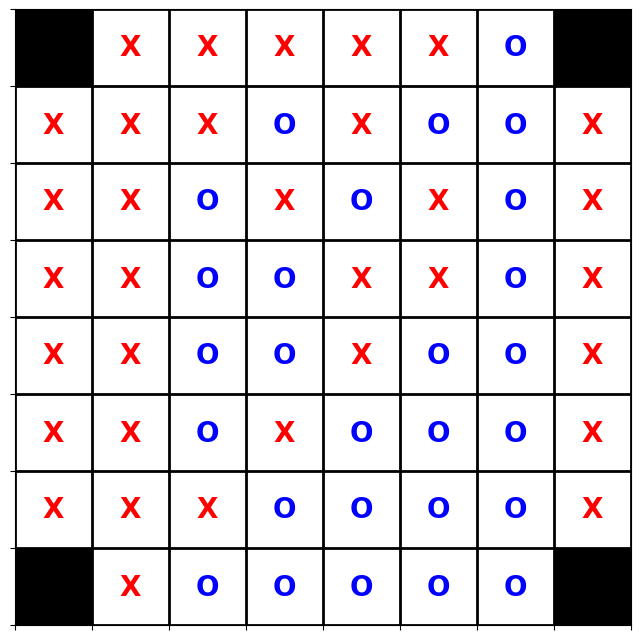

The winner is: Black
score: black:[33] white:[27]


In [1]:
%matplotlib inline

from Game import Othello_vec
from Agent import DDQNAgent
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

def draw_grid(env):
    Board = env.get_state()[0]*env.get_player()[0]
    fig, ax = plt.subplots(figsize=(8,8))
    illegal = [(0,0),(0,7),(7,0),(7,7)]
    bg = np.zeros((8,8))
    for i in illegal:
        bg[i[0]][i[1]] = -3  # change corner into black
    
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.set_xticks(np.arange(-0.5, Board.shape[1], 1))
    ax.set_yticks(np.arange(-0.5, Board.shape[0], 1))
    ax.imshow(bg, cmap='bone')
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    
    for i in range(Board.shape[0]):
        for j in range(Board.shape[1]):
            if Board[i][j] == -1:
                ax.text(j, i, 'X', color='red', va='center', ha='center', weight="bold", size=20)
            elif Board[i][j] == 1:
                ax.text(j, i, 'O', color='blue', va='center', ha='center', weight="bold", size=20)
    plt.show()

def play(agent_black, agent_white, env): 
    state, round = env.reset()
    done = np.array([False] * env.env_nums)
    
    while not done.all():
        legal_act = env.get_legal_move()  
        player = env.get_player()
        black_idx = (legal_act.any(axis=1)) & (player == -1)
        white_idx = (legal_act.any(axis=1)) & (player == 1)
        skip_idx = ~legal_act.any(axis=1)
        action = np.empty(env.env_nums, dtype=np.int32)
        
        if black_idx.any():
            action_black = agent_black.get_action(state[black_idx], legal_act[black_idx])
            action[black_idx] = action_black
        if white_idx.any():
            action_white = agent_white.get_action(state[white_idx], legal_act[white_idx])
            action[white_idx] = action_white
        
        if skip_idx.any():
            env.skip_round(skip_idx)
            player = env.get_player()
            legal_act = env.get_legal_move()
            black_idx = legal_act.any(axis=1) & (player == -1) & skip_idx
            white_idx = legal_act.any(axis=1) & (player == 1) & skip_idx
            done_idx = ~legal_act.any(axis=1) & skip_idx 
            
            if white_idx.any():
                action_white = agent_white.get_action(state[white_idx], legal_act[white_idx])
                action[white_idx] = action_white
            if black_idx.any():
                action_black = agent_black.get_action(state[black_idx], legal_act[black_idx])
                action[black_idx] = action_black
            if done_idx.any():
                env.set_done(done_idx)
        
        done, next_state, reward, round, winner, player = env.step(action)
        state = env.get_state()
        clear_output(wait=True)
        draw_grid(env)
    
    _,winner = env.get_done_score()
    black_score,white_score,_ = env.get_info()
    return black_score,white_score,winner

agent_black = DDQNAgent(eps=0, net_type='DNN')
agent_white = DDQNAgent(eps=0, net_type='DNN')

agent_black.load('./agent_black.pth')
agent_white.load('./agent_white.pth')

env = Othello_vec(1)
black_score,white_score,winner = play(agent_black, agent_white, env)
print(f"The winner is: {'Black' if winner == -1 else 'White' if winner == 1 else 'Draw'}")
print(f"score: black:{black_score} white:{white_score}")

## Play With AI
Ensure you have the necessary backend installed.\
For `%matplotlib widget`, you need `ipympl`, which can be installed via pip :\
`pip install ipympl`l

INFO:Agent:Model loaded from agent_white.pth


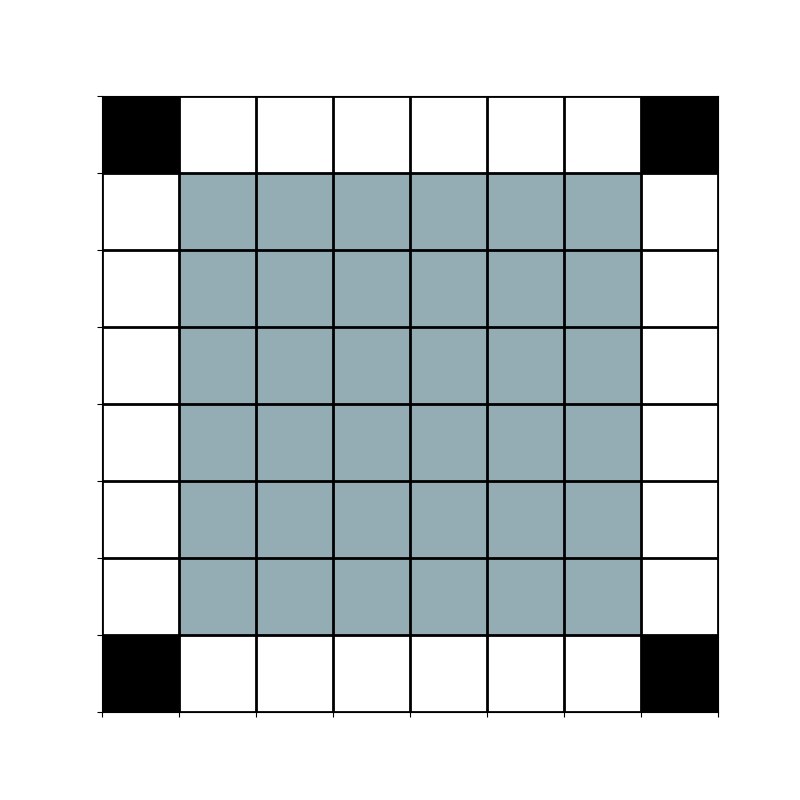

In [4]:
%matplotlib widget
from Game import Othello_vec
from Agent import DDQNAgent
import matplotlib.pyplot as plt
import numpy as np

def draw_grid(env,agent):
    Board = env.get_state()[0]
    fig, ax = plt.subplots(figsize=(8,8))
    
    def update_fig(Board,legal_move):
        plt.cla()
        illegal = [(0,0),(0,7),(7,0),(7,7)]
        bg = np.zeros((8,8))
        for i in illegal:
            bg[i[0]][i[1]] = -3  # change corner into black
            
        for i in np.arange(64)[legal_move[0]]:
            bg[i//8][i%8] = -1  # change legal moves into gray
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])
        ax.set_xticks(np.arange(-0.5, Board.shape[1], 1))
        ax.set_yticks(np.arange(-0.5, Board.shape[0], 1))
        ax.imshow(bg,cmap = 'bone')
        ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
        for i in range(Board.shape[0]):
            for j in range(Board.shape[1]):
                if(Board[i][j] == -1):
                    ax.text(j, i,'X',color='red', va='center', ha='center',weight="bold",size=20)
                elif(Board[i][j] == 1):
                    ax.text(j, i,'O',color='blue',va='center', ha='center',weight="bold",size=20)

    def onclick(event):
        x = int(event.xdata+0.5)
        y = int(event.ydata+0.5)
        legal_move = env.get_legal_move()
        # plt.gca().set_title(f'x{x} y{y}')
        plt.gcf().canvas.draw()
        if y*8+x in np.arange(64)[legal_move[0]]:
            done,state,reward,round,winner,player= env.step(np.array([y*8+x]))
            legal_move = env.get_legal_move()  
            if legal_move.any(axis=1):
                action = agent.get_action(state,legal_move).astype(int)
                done,state,reward,round,winner,player = env.step(action)
            else:
                done,state,reward,round,winner,player = env.step(np.array([-1]))
            Board = state[0]
            black,white,round = env.get_info()
            legal_move = env.get_legal_move()
            update_fig(Board,legal_move)
            plt.gca().set_title(f'Round:{int(round[0])} You:{black[0]} AI:{white[0]}')
            plt.gcf().canvas.draw()


    # Connect the onclick event handler
    legal_move = env.get_legal_move()
    state = env.get_state()
    # action = agent.get_action(state,legal_move).astype(int)
    # done,state,reward,round,winner,player = env.step(action)
    # legal_move = env.get_legal_move()
    update_fig(Board,legal_move)
    fig.canvas.mpl_connect('button_press_event', onclick)
    plt.show()

# Build env
env = Othello_vec(1)

# you can change eps into non-zero value (e.q. 0.1) to add some randomness
agent= DDQNAgent(eps=0,net_type='DNN')

# load your agent here ->
agent.load('agent_white.pth')
draw_grid(env,agent)

